In [1]:
# Performs a statistical subtraction of background galaxies

# Last edited Aug. 22, 2017 at 5:05pm

In [3]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *

In [4]:
# Reading in data and assigning it to variables even though Greg seems to think it's a waste of time.

# Read in data
hdulist = fits.open('http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/external/survey-dr3-specObj-dr13.fits') # survey
hdulist2 = fits.open('https://data.sdss.org/sas/dr13/sdss/spectro/redux/specObj-dr13.fits')
tbdata = hdulist[1].data
tbdata2 = hdulist2[1].data

# Put data in arrays

# Object ID from survey file; value -1 for non-matches
objid = []
objid = tbdata.field('OBJID') 

# Only galaxies included
gal_type = []
gal_type = tbdata.field('TYPE') 

# RA
ra = []
ra = tbdata.field('RA')

# Dec
dec = []
dec = tbdata.field('DEC')

# Number of observations of source from legacy file
# Not cut for LOWZ
obs = []
obsmatch = []
obs = tbdata.field('DECAM_NOBS') 
obsmatch = obs[np.where(((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5))] # & (lowz_tar == 1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))]

# Put number of observations per filter into arrays that match the filter
uobs = []
gobs = []
robs = []
iobs = []
zobs = []
yobs = []

b = np.array(obsmatch)
uobs = b[:,0]
gobs = b[:,1]
robs = b[:,2]
iobs = b[:,3]
zobs = b[:,4]
yobs = b[:,5]

# Put flux data in an array from legacy file
# Flux has ugrizY, so needs to be divided into 6 arrays
flux =[]
fluxmatch = []

# Flux from DECAM
# Not cut for LOWZ
flux = tbdata.field('DECAM_FLUX')
fluxmatch = flux[np.where(((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5))]

# Divide flux arrays into 6 arrays
uflux = []
gflux = []
rflux = []
iflux = []
zflux = []
yflux = []

a = np.array(fluxmatch)
uflux = a[:,0]
gflux = a[:,1]
rflux = a[:,2]
iflux = a[:,3]
zflux = a[:,4]
yflux = a[:,5]

# Class of object
gal_class = []
gal_class = tbdata2.field('CLASS')

# What survey the data is from
survey = []
survey = tbdata2.field('SURVEY')

# SPECPRIMARY; set to 1 for primary observation of object, 0 otherwise
spec = []
spec = tbdata2.field('SPECPRIMARY')

# Bitmask of spectroscopic warning values; need set to 0
zwarn_noqso = []
zwarn_noqso = tbdata2.field('ZWARNING_NOQSO')

# Spectroscopic classification for certain redshift?
class_noqso = []
class_noqso = tbdata2.field('CLASS_NOQSO')

# Redshift of galaxies according to sdss
redshift = []
redshift = tbdata2.field('Z') 

# Array for LOWZ targets
targets = []
targets = tbdata2.field('BOSS_TARGET1')

# Section of code to find LOWZ targets

# Function to find LOWZ targets
def divideBy2(decNumber):
	np.vectorize(decNumber)
	remstack = Stack()
	
	if decNumber == 0: return "0"
	
	while decNumber > 0:
		rem = decNumber % 2
		remstack.push(rem)
		decNumber = decNumber // 2
		
	binString = ""
	while not remstack.isEmpty():
		binString = binString + str(remstack.pop())
			
	return binString

divideBy2Vec = np.vectorize(divideBy2)

a = divideBy2Vec(targets) # gives binary in string form
bin2int = [int(i) for i in a] # converts binary strings to integer
tar = np.array(bin2int) # puts list of integers into numpy array
c = tar % 2 # divide by two again to see if the binary number ends in zero
lowz_tar = np.array(c)

# Number of observations for LOWZ targets
obs_LOWZ = obs[np.where(((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (lowz_tar == 1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))]

obs_LOWZ_array = np.array(obs_LOWZ)
uobs_LOWZ = obs_LOWZ_array[:,0]
gobs_LOWZ = obs_LOWZ_array[:,1]
robs_LOWZ = obs_LOWZ_array[:,2]
iobs_LOWZ = obs_LOWZ_array[:,3]
zobs_LOWZ = obs_LOWZ_array[:,4]
yobs_LOWZ = obs_LOWZ_array[:,5]

# Flux for LOWZ targets
flux_LOWZ = flux[np.where(((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (lowz_tar == 1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))]

flux_LOWZ_array = np.array(flux_LOWZ)
uflux_LOWZ = flux_LOWZ_array[:,0]
gflux_LOWZ = flux_LOWZ_array[:,1]
rflux_LOWZ = flux_LOWZ_array[:,2]
iflux_LOWZ = flux_LOWZ_array[:,3]
zflux_LOWZ = flux_LOWZ_array[:,4]
yflux_LOWZ = flux_LOWZ_array[:,5]

In [5]:
# This next part of the code creates a CMD for all galaxies in the EDR

In [6]:
# Finds the flux in the g and r band that have at least 3 obervations in each with the flux in each > 0, calculates
# the magnitude in g and r, and calculates the (g-r) color

# Finds flux that correspond with at least 3 observations and a flux > 0
gflux_match = gflux[np.where((gobs >= 3) & (robs >= 3) & (gflux > 0.) & (rflux > 0.))]
rflux_match = rflux[np.where((gobs >= 3) & (robs >= 3) & (rflux > 0.) & (gflux > 0.))]

gmag = 22.5 - 2.5 * np.log10(gflux_match)
rmag = 22.5 - 2.5 * np.log10(rflux_match)

color = gmag - rmag

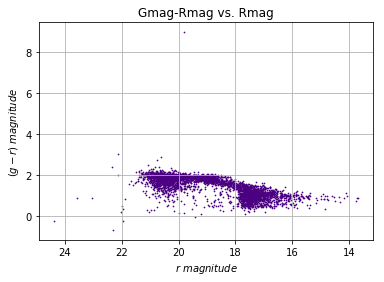

In [7]:
# Plot
plt.scatter(rmag, color, s = .5, color = 'indigo') #, label = 'EDR All Cuts')

plt.gca().invert_xaxis()

plt.grid(True)
plt.title('Gmag-Rmag vs. Rmag')
plt.xlabel(r'$r$ $magnitude$')
plt.ylabel(r'$(g-r)$ $magnitude$')

# plt.legend(loc='upper right')

plt.show()

In [8]:
print(len(color))

3688


In [9]:
# This part of the code calculates surface density as a function of (g-r) color and magnitude. Returns a 10x10 array.

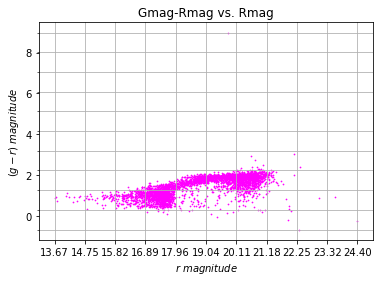

In [10]:
# Calculate surface density
Nfield = np.histogram2d(rmag, color, bins=[10,10], normed=False) #flip x and y axis in bins because that's just how this thing rolls

# print(H)

fig, ax = plt.subplots()
ax.set_xticks([ 13.67403889,  14.74635315,  15.81866837,  16.89098167, 17.96329689,  19.03561211,  20.10792542,  21.18024063, 22.25255585,  23.32486916,  24.39718437], minor=False)
ax.set_yticks([-0.65635681,  0.30690479,  1.2701664 ,  2.233428  ,  3.19668961, 4.15995121,  5.12321281,  6.08647442, 7.04973602,  8.01299763, 8.97625923], minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

plt.scatter(rmag, color, s = .5, color = 'magenta') #, label = 'EDR All Cuts')

# plt.gca().invert_xaxis()

# plt.grid(True)
plt.title('Gmag-Rmag vs. Rmag')
plt.xlabel(r'$r$ $magnitude$')
plt.ylabel(r'$(g-r)$ $magnitude$')

# plt.legend(loc='upper right')

plt.show()

# I flipped the plot because it's easier for me to connect it with the surface_density matrix that way.

In [11]:
# print(Nfield[0]) # Nfield[0] is the histogram part. Nfield[1] and Nfield[2] are the xedges and yedges, respectively.
# Also, these values go from low to high x-values, which gets confusing when looking at the CMD.

In [12]:
# Test to illustrate how historgram2d works

# x = [2,6,7,9,10,4,5,12,15,10]
# y = [1,4,3,8,7,3,11,12,18,12]

# fig, ax = plt.subplots()
# ax.set_xticks( [2. ,   8.5,  15.], minor=False)
# ax.set_yticks([ 1. ,   9.5,  18.], minor=True)
# ax.xaxis.grid(True, which='major')
# ax.yaxis.grid(True, which='minor')

# plt.scatter(x,y)

# plt.show()

# H = np.histogram2d(x, y, bins=[2,2], normed=False)
# print(H)

In [13]:
surface_density = Nfield[0] / (3.24 * 10**8) # area of EDR in units of square arcsec
surface_density = np.array(surface_density)
print(surface_density.shape)
# print(Nfield[0])
print(surface_density)
print(len(surface_density))

(10, 10)
[[  0.00000000e+00   3.70370370e-08   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.41975309e-07   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   7.31481481e-07   4.32098765e-08   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.54320988e-08   2.53395062e-06   8.05555556e-07   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.08641975e-09   1.41975309e-07   1.31172840e-06   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.23456790e-08   7.09876543e-08   2.08333333e-06   0.00000000e+00
    0.00000000e+00   0.00000000e+00 

In [14]:
# This part of the code finds the area in which I will look for satellite galaxies: A = pi*(search radius). It 
# includes a modified Python Code for this cosmological calculator (http://www.astro.ucla.edu/~wright/CC.python),
# Which is in turn modified from http: http://www.astro.ucla.edu/~wright/CosmoCalc.html. 

# A search radius, and therefore an area, needs to be found for each LRG. So the ultimate output of this part should 
# be a 10x10x(number of LRGs) matrix. Because each LRG is a different redshift, I need the cosmological calculator to
# produce a scale value so I can convert from the search radius (in kpc) to an angle in arcsecond. After using the
# angle to calculate the search area A, I use A to calculate the expected number of galaxies around each LRG. The 
# structure of the data at the end should be a 10x10 square (like the surface density) with a depth of the number of
# LRGs in the sample.

In [40]:
# Section of code to find scale factor for distance so I can calculate the area around LRG

# Redshift values
redshift_cut = redshift[np.where((lowz_tar == 1) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (objid > -1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')) & ((gal_type == 'DEV') | (gal_type == 'EXP') | (gal_type == 'COMP') | (gal_type == 'SIMP')))]
z = redshift_cut[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]

# Calculate scale to get areas
H0 = 69.6
WM = 0.286
WV = 0.714
# z = 0.209855

# initialize constants

WR = 0.        # Omega(radiation)
WK = 0.        # Omega curvaturve = 1-Omega(total)
c = 299792.458 # velocity of light in km/sec
Tyr = 977.8    # coefficent for converting 1/H into Gyr
DTT = 0.5      # time from z to now in units of 1/H0
DTT_Gyr = []  # value of DTT in Gyr
age = 0.5      # age of Universe in units of 1/H0
age_Gyr = []  # value of age in Gyr
zage = 0.1     # age of Universe at redshift z in units of 1/H0
zage_Gyr = [] # value of zage in Gyr
DCMR = 0.0     # comoving radial distance in units of c/H0
DCMR_Mpc = [] 
DCMR_Gyr = []
DA = 0.0       # angular size distance
DA_Mpc = []
DA_Gyr = []
kpc_DA = []
DL = 0.0       # luminosity distance
DL_Mpc = []
DL_Gyr = []   # DL in units of billions of light years
V_Gpc = []
a = 1.0        # 1/(1+z), the scale factor of the Universe
az = 0.5       # 1/(1+z(object))

h = H0/100.
WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
WK = 1-WM-WR-WV

for j in range(len(z)):
	az = 1.0/(1+1.0*z[j])
	age = 0.
	n=1000         # number of points in integrals
	for i in range(n):
		a = az*(i+0.5)/n
		adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
		age = age + 1./adot

	zage = az*age/n
	zage_Gyr.append((Tyr/H0)*zage)
	DTT = 0.0
	DCMR = 0.0

	# do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
	for i in range(n):
		a = az+(1-az)*(i+0.5)/n
		adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
		DTT = DTT + 1./adot
		DCMR = DCMR + 1./(a*adot)

	DTT = (1.-az)*DTT/n
	DCMR = (1.-az)*DCMR/n
	age = DTT+zage
	age_Gyr.append(age*(Tyr/H0))
	DTT_Gyr.append((Tyr/H0)*DTT)
	DCMR_Gyr.append((Tyr/H0)*DCMR)
	DCMR_Mpc.append((c/H0)*DCMR)

	# tangential comoving distance

	ratio = 1.00
	x = sqrt(abs(WK))*DCMR
	if x > 0.1:
		if WK > 0:
			ratio =  0.5*(exp(x)-exp(-x))/x 
		else:
			ratio = sin(x)/x
	else:
		y = x*x
		if WK < 0: y = -y
		ratio = 1. + y/6. + y*y/120.
	DCMT = ratio*DCMR
	DA = az*DCMT
	DA_Mpc.append((c/H0)*DA)
	kpc_DA.append(DA_Mpc[j]/206.264806)
	DA_Gyr.append((Tyr/H0)*DA)
	DL = DA/(az*az)
	DL_Mpc.append((c/H0)*DL)
	DL_Gyr.append((Tyr/H0)*DL)

	# comoving volume computation

	ratio = 1.00
	x = sqrt(abs(WK))*DCMR
	if x > 0.1:
		if WK > 0:
			ratio = (0.125*(exp(2.*x)-exp(-2.*x))-x/2.)/(x*x*x/3.)
		else:
			ratio = (x/2. - sin(2.*x)/4.)/(x*x*x/3.)
	else:
		y = x*x
		if WK < 0: y = -y
		ratio = 1. + y/5. + (2./105.)*y*y
	VCM = ratio*DCMR*DCMR*DCMR/3.
	V_Gpc.append(4.*pi*((0.001*c/H0)**3)*VCM)
    
print(z[0])
print(z[1])
print(z[2])
print(kpc_DA[0])
print(kpc_DA[1])
print(kpc_DA[2])

0.209855
0.335372
0.360255
3.45274094333
4.8474024974
5.07993412145


In [16]:
# Section of code that converts satellite search radius rp to arcsec and calculates area A

theta = []
A = []
rp = 1000.

for i in range(len(kpc_DA)):
	theta.append(rp * (1/kpc_DA[i])) # converts rp in kpc to arcsec
	A.append(np.pi * theta[i]**2) # calculates the area around each LRG
	
A = np.array(A)
print(A.shape)

(446,)


In [17]:
# Section of code that calculates the number of expected galaxies (Nexp) as a function of color and magnitude


B = []

for k in range(len(A)):
    for i in range(surface_density.shape[0]):
        for j in range(surface_density.shape[1]):
            B.append(A[k] * surface_density[i,j])

B = np.array(B)
        
# Reshapes B array

Nexp = np.reshape(B, (446,10,10))

# print(sd.shape)
# print(sd)
# print(B.shape)
# print(B)
print(Nexp.shape)
print(Nexp[np.where(Nexp > 0)])



# B = []

# for i in range(len(surface_density)):
# 	for j in range(len(surface_density)):
# 		B.append(A * surface_density[i,j])

# B = np.array(B)
# # print(len(B))
        
# # Reshapes B array

# Nexp = np.reshape(B, (10,10,446))

# print(B.shape)
# print(B[1,0])
# print(Nexp.shape)

(446, 10, 10)
[ 0.00976019  0.03741405  0.19276368 ...,  0.00066003  0.00066003
  0.00066003]


In [18]:
# Testing to see if Nexp is what I think it is

# print(Nexp[1,1,1]) # index order: surface_density (first two slots), A
# print(A[1])
# print(surface_density[1,1])
# print(A[1] * surface_density[1,1])

In [19]:
print(len(Nexp[0,0]))
print(Nexp.shape[1])

10
10


In [20]:
# This is what I think the previous chunks of code are doing. For every surface density, the code goes through and
# muliplies by every search area. In other words, each surface density is multiplied 446 times (the number of LRGs).
# The data is stored, then, in a 3D block. The coordinates of face of the block coorespond to the coordinates of the 
# surface_density matrix. The coordinates of the depth of the block coorespond to the coordinates of the A array
# (the array that holds all the search areas). So I'm pretty sure I have a matrix of values for the expected number
# of satellite galaxies.

In [21]:
# This part of the code is where I try to count the number of galaxies are in a radius around an LRG. The plan is 
# inefficient, but it's what I have at the moment: I want to measure the distances between each individual LRG and
# every other galaxy in the EDR. Then I will find what number of those are within 1000 kpc of the LRG. 
# This will be Ngal.

In [22]:
# Makes arrays for RA and Dec for LOWZ LRGs only and for all EDR galaxies 

# Creates an array of RA and Dec for the 446 LOWZ LRGs

ra_cut = ra[np.where((lowz_tar == 1) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (objid > -1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')) & ((gal_type == 'DEV') | (gal_type == 'EXP') | (gal_type == 'COMP') | (gal_type == 'SIMP')))]
ra_lrg = ra_cut[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]

dec_cut = dec[np.where((lowz_tar == 1) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (objid > -1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')) & ((gal_type == 'DEV') | (gal_type == 'EXP') | (gal_type == 'COMP') | (gal_type == 'SIMP')))]
dec_lrg = dec_cut[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]

print(len(ra_lrg))
print(len(dec_lrg))

# Create an array for RA and Dec for all EDR sources

ra_edr = ra[np.where((ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & ((gal_type == 'DEV') | (gal_type == 'EXP') | (gal_type == 'COMP') | (gal_type == 'SIMP')))]
dec_edr = dec[np.where((ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & ((gal_type == 'DEV') | (gal_type == 'EXP') | (gal_type == 'COMP') | (gal_type == 'SIMP')))]

print(len(ra_edr))
print(len(dec_edr))

446
446
5131
5131


In [23]:
# This section creates new_ra and new_dec arrays. These are ra_lrg - ra_edr and dec_lrg - dec_edr, respectively. The
# new ra and dec are then converted into arcsececond, and then to kpc

new_ra = []
newra = []

new_dec = []
newdec = []

ra_arcsec = []
dec_arcsec = []

ra_kpc = []
dec_kpc = []

dist = []

# Calculate the difference between LRG RA/Dec and satellite RA/Dec

for i in range(len(ra_lrg)):
#     if (ra_lrg != ra_edr): # avoids subtracting ra/dec of lrg from itself
    newra = ra_lrg[i] - ra_edr
#     else:
#         newra = 0
    new_ra.append(newra)
    
for i in range(len(dec_lrg)):
#     if (dec_lrg != dec_edr):
    newdec = dec_lrg[i] - dec_edr
#     else:
#         newdec = 0
    new_dec.append(newdec)
    
new_ra = np.array(new_ra)
new_dec = np.array(new_dec)

# print(new_ra.shape[0])
# print(new_dec.shape)
# print(newra[0,0])
# print(ra_lrg[0] - ra_edr[0])


# Convert to arcsecond

for i in range(new_ra.shape[0]):
    ra_arcsec.append(new_ra[i] * 3600)

ra_arcsec = np.array(ra_arcsec)


for i in range(new_dec.shape[0]):
    dec_arcsec.append(new_dec[i] * 3600)

dec_arcsec = np.array(dec_arcsec)


# Convert to kpc using scale from cosomological calculator

for i in range(ra_arcsec.shape[0]):
    ra_kpc.append(ra_arcsec[i] * kpc_DA[i])

ra_kpc = np.array(ra_kpc)


for i in range(dec_arcsec.shape[0]):
    dec_kpc.append(dec_arcsec[i] * kpc_DA[i])

dec_kpc = np.array(dec_kpc)


# Calculate distance from LRG to satellites

for i in range(ra_kpc.shape[0]):
    dist.append(np.sqrt((ra_kpc[i])**2 + (dec_kpc[i])**2))

dist = np.array(dist)

# print(new_ra.shape)
# print(ra_lrg[1])
# print(ra_edr[2])
# print(new_ra[1,2])
# print(ra_lrg[1]-ra_edr[2])

# print(ra_arcsec.shape)
# print(ra_arcsec[10,30])
# print((new_ra[10,30] * 3600))

# print(ra_kpc.shape)
# print(ra_kpc[10,10])
# print(ra_arcsec[10,10] * kpc_DA[10])

# print(dist.shape)
# print(np.sqrt((ra_kpc[10,11])**2 + (dec_kpc[10,11])**2))
# print(dist[10,11])

d = dist[1]
print(d.shape)
print(len(d[np.where(d < 1000)]))
print(d[np.where(d < 1000)])

(5131,)
4
[ 650.68132108    0.          716.00436827  649.60145039]


In [24]:
print(ra_lrg[1])
print(dec_lrg[1])

241.617707238
6.86264630165


In [25]:
# In which I create an array of how many galaxies are within the search radius of each LRG. The array should be 1D and
# 446 elements long.

Ngal = []

for i in range(dist.shape[0]):
    d = dist[i]
    Ngal.append(len(d[np.where(d < 1000.)]))

Ngal = np.array(Ngal)
Ngal = Ngal - 1 # Need to subtract one because I did not eliminate the LRG RA/Dec from the ra_edr and dec_edr

print(Ngal.shape)
print(len(Ngal[np.where(Ngal == 0)]))
print(Ngal[1])

(446,)
42
3


In [26]:
# This is the part of the code where I calculate how many extra neighbors each LRG has. This is Nsat.

In [27]:
Nsat = []

for i in range(Nexp.shape[0]):
    for j in range(Nexp.shape[1]):
        for m in range(Nexp.shape[2]):
            s = Ngal[i] - Nexp[i,j,m]
            Nsat.append(s)
            
Nsat = np.array(Nsat)
Nsat = np.reshape(Nsat, (446,10,10))

print(Nsat.shape)

print(Ngal[1] - Nexp[1,9,0])
print(Ngal[1])
print(Nexp[1,9,0])
print(Nsat[1,9,0])

(446, 10, 10)
2.99958734539
3
0.000412654606896
2.99958734539


In [28]:
# I think I am misunderstanding what goes on when I reshape a 1D array into a 3D array, so below are just a bunch of
# tests on smaller and simpler arrays so I can figure out what is going on. Code for this is in tests.ipynb and I think
# it is fixed.

In [29]:
# This part of the code calculates the average number of Nsat for every LRG as a function of (g-r) color and magnitude.
# This collapses a 3D array into a 1D array. As it turns out, none of the LRGs have an average Nsat == 0.

In [30]:
# Tsat = []
# Tgal = np.array([1,2])
# Texp = np.array([2,4,8,10,4,8,16,20])
# Texp = np.reshape(Texp, (2,2,2))

# # for k in range(len(Tgal)):
# for i in range(Texp.shape[0]):
#     for j in range(Texp.shape[1]):
#         for m in range(Texp.shape[2]):
#             s = Tgal[i] - Texp[i,j,m]
#             Tsat.append(s)
            
# Tsat = np.array(Tsat)
# Tsat = np.reshape(Tsat, (2,2,2))

# print(Tsat)

avg = []
sat_avg = []

# print(len(Nsat))

for i in range(Nsat.shape[0]):
    new_array = np.array(Nsat[i])
# print(new_array)
    avg = np.mean(new_array)
# print(avg)
    sat_avg.append(avg)
            
sat_avg = np.array(sat_avg)
        
# avg0 = (-1 + -3 + -7 + -9) / 4
# avg1 = (-2 + -6 + -14 + -18) / 4
# print(avg0)
# print(avg1)
print(len(sat_avg))
print(sat_avg.shape)


Navg = []

for i in range(Nsat.shape[0]):
    new_array = np.array(Nsat[i])
    Nsum = np.sum(new_array)
    Navg.append(Nsum/len(Ngal))
    
Navg = np.array(Navg)

print(len(Navg))
print(Navg.shape)

446
(446,)
446
(446,)


In [31]:
# idk...I guess I'll plot some histograms to see what's up?

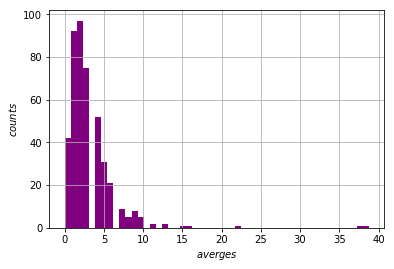

In [32]:
# Plot histogram of number of satellites per LRG averaged over number of CM bins

plt.hist(sat_avg, bins = 50, color = 'purple')

plt.grid(True)
# plt.title('Magnitude Distribution (g)')
plt.xlabel(r'$averges$')
plt.ylabel(r'$counts$')

plt.show()

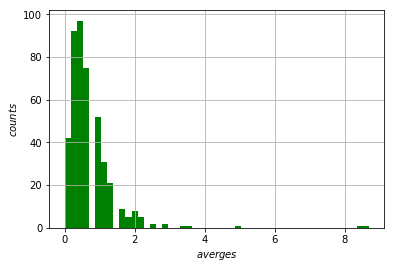

In [33]:
# Plot histogram of number of satellites per LRG averaged over the number of LRGs

plt.hist(Navg, bins = 50, color = 'green')

plt.grid(True)
# plt.title('Magnitude Distribution (g)')
plt.xlabel(r'$averges$')
plt.ylabel(r'$counts$')

plt.show()

In [34]:
# The shape of these look exactly the same, which is really suspicious to me.
# I need to talk to Greg about this.